# Damage Size Regression on Real-world Data Data - Baseline
In this notebook, we conduct experiments to be able to compare to a baseline. Just to make sure, we repeat the experiment several times to make sure that the previously established cross-validation setup gives reliable results also with this approach.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/mixed_regression_AA_BASE.ipynb)

In [1]:
random_state = None

## Prerequisites

In [2]:
import sys
import os
from pathlib import Path
import pandas as pd

# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import time
import glob
import sklearn
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

#...and download raw data if not already downloaded
from data_utils import init_data
init_data(syn_data_path=SYN_DATA_PATH, real_data_path=REAL_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import (
    get_real_regression_scoring,
    SHM_Scoring)
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    extract_metrics)
from data_utils import (load_reg_data_base,
                        load_syn_reg_data,
                        FEATURE_LIST)
from shm_experiments import conduct_aa_mixed_reg_experiment

time passed: 4.74 s
downloading synthetic data successful: True
time passed: 1.64 s
downloading real world data successful: True


In [5]:
result_file = "synthetic_regression_AA_baseline.pkl"
result_file = Path(RESULT_PATH, result_file)

## Data Loading

### Synthetic Data

In [6]:
Xsyn, ysyn = load_reg_data_base(data_path=SYN_DATA_PATH,
                                min_radius = 1.9,
                                cache=True)

In [7]:
Xsyn.shape

(28302, 801)

In [8]:
ctr = Counter(ysyn)
ctr

Counter({0.0: 990,
         2.2: 979,
         2.5: 979,
         2.8: 978,
         3.1: 986,
         3.4: 972,
         3.8: 973,
         4.1: 976,
         4.4: 979,
         4.7: 976,
         5.0: 977,
         6.7: 981,
         8.3: 972,
         10.0: 973,
         12.0: 969,
         14.0: 978,
         16.0: 980,
         18.0: 976,
         20.0: 974,
         22.0: 975,
         24.0: 980,
         26.0: 973,
         28.0: 983,
         30.0: 977,
         32.0: 967,
         34.0: 971,
         36.0: 976,
         38.0: 964,
         40.0: 968})

### Real World Data

In [9]:
Xreal, yreal = load_reg_data_base(data_path=REAL_DATA_PATH,
                                  min_radius = 1.,
                                  cache=False,
                                  synthetic=False)

In [10]:
Xreal.shape

(225, 801)

In [11]:
ctr = Counter(yreal)
ctr

Counter({0.0: 9,
         1.5: 9,
         2.5: 9,
         3.5: 9,
         4.5: 9,
         5.5: 9,
         7.0: 9,
         8.0: 9,
         10.0: 9,
         12.0: 9,
         14.0: 9,
         16.0: 9,
         17.0: 9,
         19.0: 9,
         21.0: 9,
         23.0: 9,
         25.0: 9,
         27.0: 9,
         29.0: 9,
         31.0: 9,
         33.0: 9,
         35.0: 9,
         37.0: 9,
         39.0: 9,
         40.0: 9})

## A-A Experiments

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

In [13]:
estimator = KNeighborsRegressor(n_neighbors=1)
pipeline = Pipeline([('est', estimator)])

In [14]:
scoring = get_real_regression_scoring()

results = conduct_aa_mixed_reg_experiment(Xsyn=Xsyn, ysyn=ysyn,
                                          Xreal=Xreal, yreal=yreal,
                                          estimator=pipeline,
                                          name="BASE",
                                          n_repeats=5,
                                          n_splits=32,
                                          test_size=0.1,
                                          scoring=scoring,
                                          random_state=random_state)

## Store results for later

In [15]:
results.to_pickle(result_file)

## Plot some results for overview

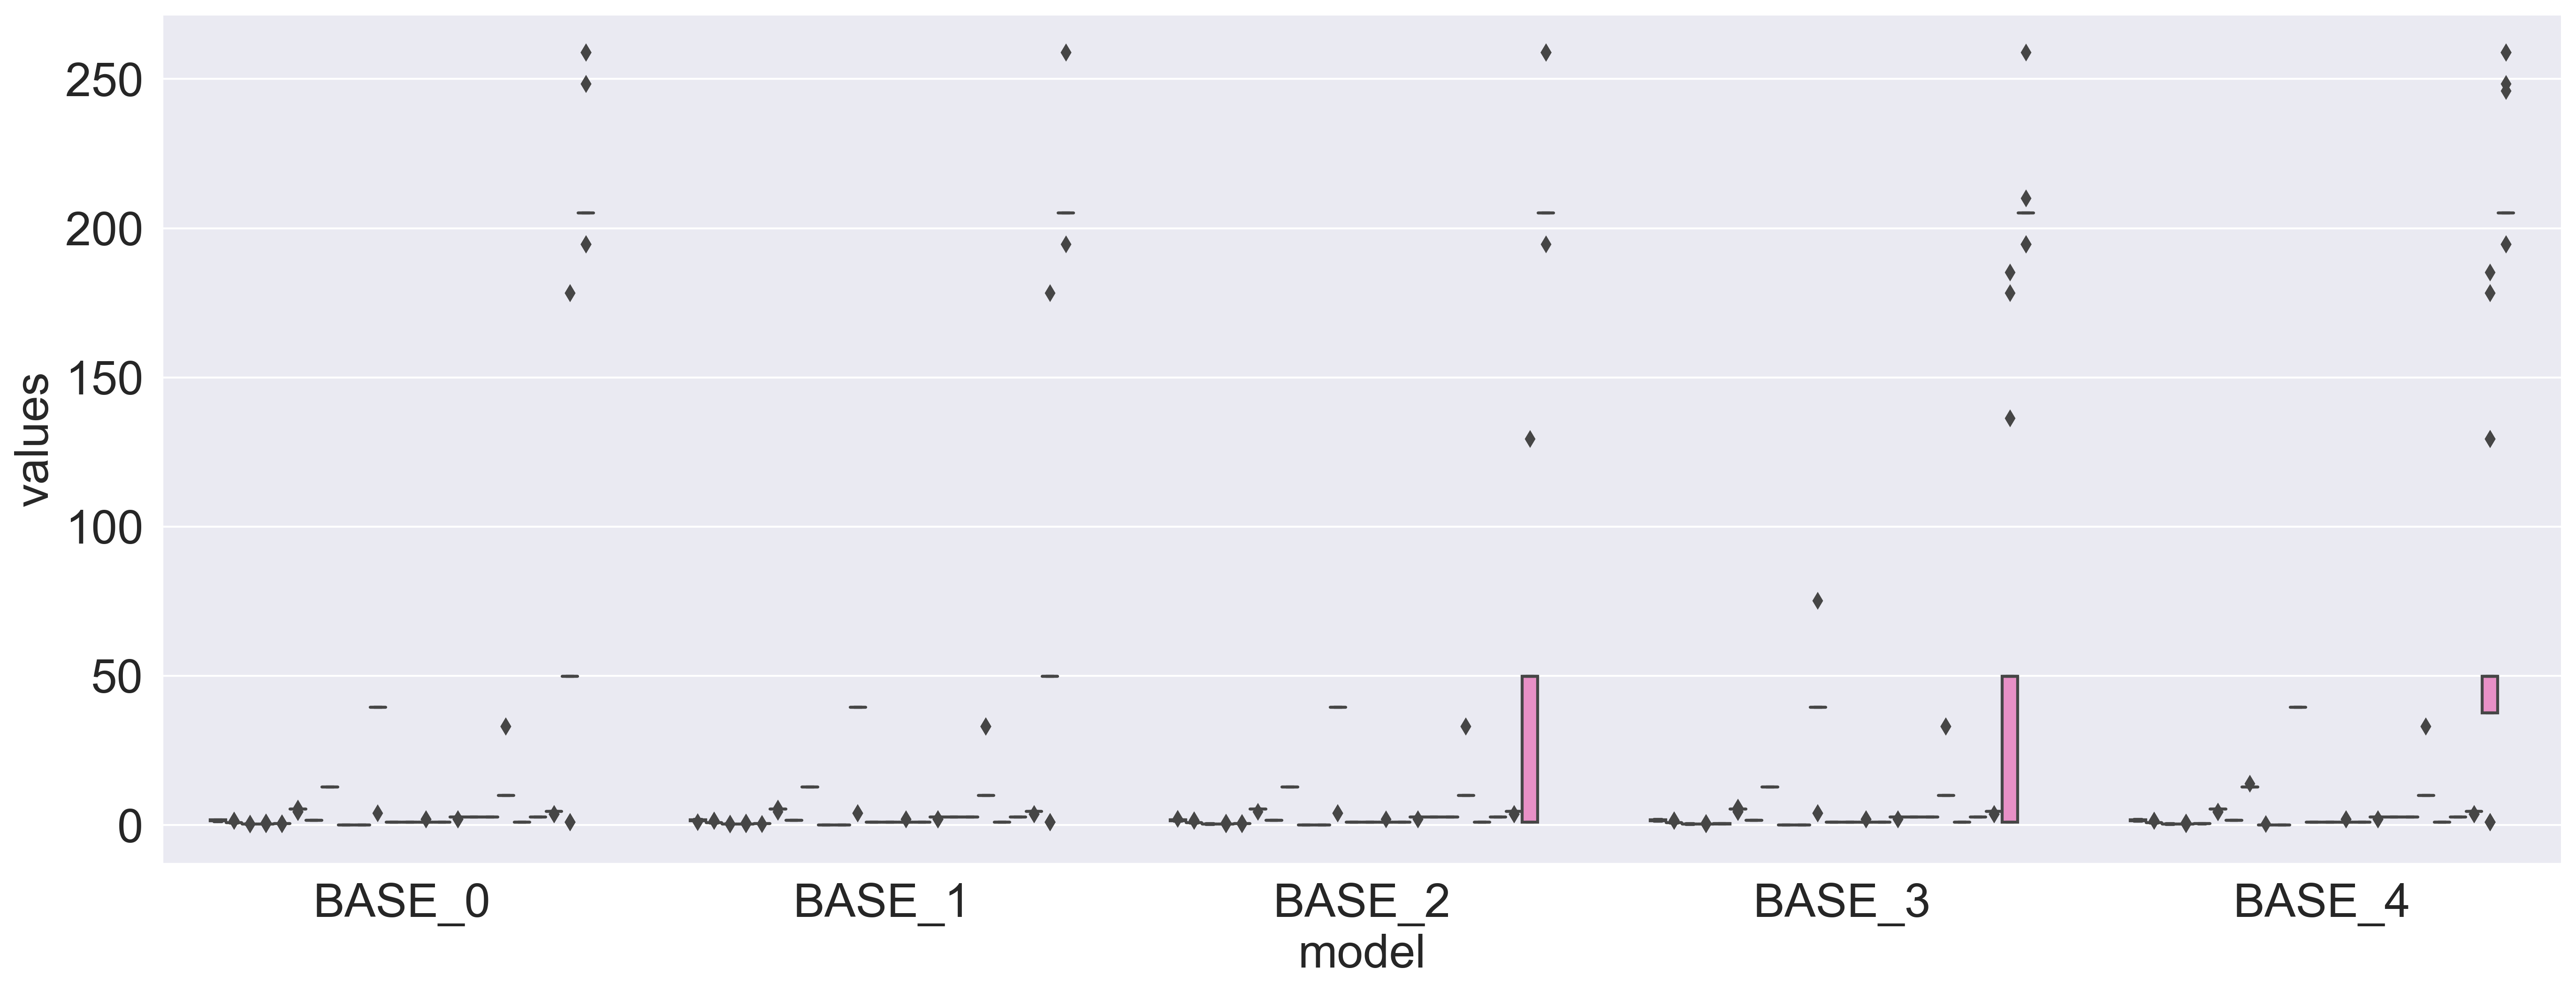

In [16]:
shm_scoring = SHM_Scoring()

fig = plot_metrics(extract_metrics(results, shm_scoring.REAL_MSE_RESULTS))
plt.gca().get_legend().remove()
plt.show()

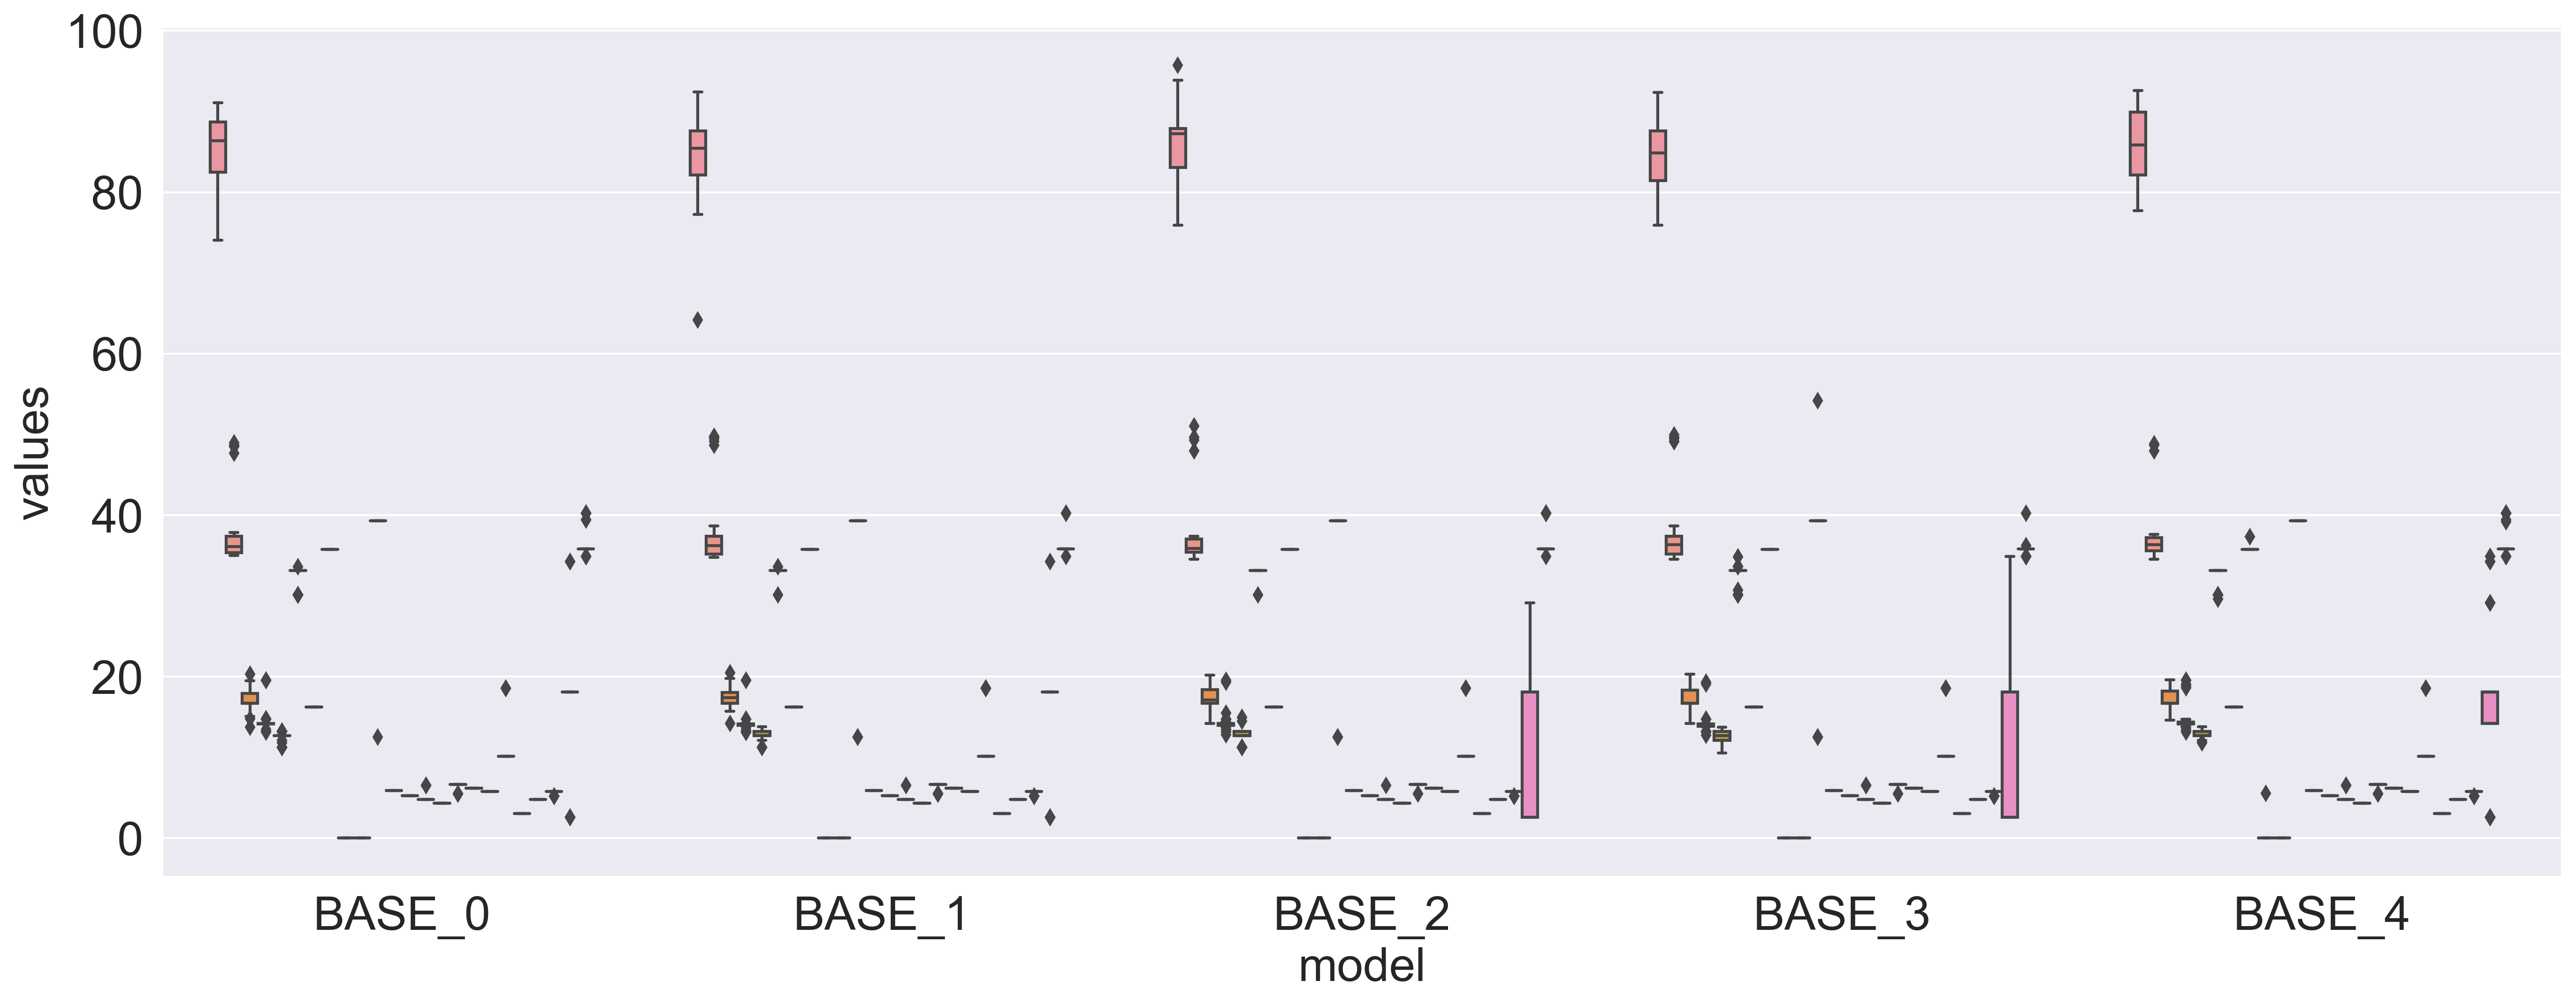

In [17]:
fig = plot_metrics(extract_metrics(results, shm_scoring.REAL_REL_ERROR))
plt.gca().get_legend().remove()
plt.show()